In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim 

In [2]:
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from tmv_app.tasks import get_coherence, get_exclusivity

### DTM runs

In [3]:
method="BD"
search_id = 83
#run_qs =  RunStats.objects.filter(psearch__id=search_id, method=method, status=3, alpha=0.01, top_chain_var=0.005)
run_qs =  RunStats.objects.filter(psearch__id=search_id, method=method, status=3)

run_ids = [run_id[0] for run_id in run_qs.values_list('run_id')]
print(run_ids)

[2123, 2122, 2121, 2120, 2119, 2112, 2118, 2111]


In [4]:
for run_id in run_ids:
    if not RunStats.objects.get(run_id=run_id).coherence:
        print("Calculating coherence for run {}".format(run_id))
        get_coherence(run_id)

Calculating coherence for run 2123
Calculating coherence for run 2122
Calculating coherence for run 2121
Calculating coherence for run 2120
Calculating coherence for run 2119
Calculating coherence for run 2112
Calculating coherence for run 2118
Calculating coherence for run 2111


In [5]:
for run_id in run_ids:
    if not RunStats.objects.get(run_id=run_id).exclusivity:
        print("Calculating exclusivity for run {}".format(run_id))
        get_exclusivity(run_id)

Calculating exclusivity for run 2123
Calculating exclusivity for run 2122
Calculating exclusivity for run 2121
Calculating exclusivity for run 2120
Calculating exclusivity for run 2119
Calculating exclusivity for run 2112
Calculating exclusivity for run 2118
Calculating exclusivity for run 2111


In [7]:
run_df = pd.DataFrame.from_dict(run_qs.values('run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter'))

#run_df.set_index('run_id')
run_df = run_df.sort_values('run_id').set_index('run_id')
run_df[run_df["K"]== 45]

,K,alpha,coherence,exclusivity,max_iter,rng_seed,top_chain_var
run_id,,,,,,,
2111,45,0.01,0.508955,0.742253,50,1,0.005
2118,45,0.10,0.374046,0.698753,50,1,0.100
2119,45,0.10,0.416262,0.824821,50,1,0.050
2120,45,0.10,0.491302,0.871996,50,1,0.010
2121,45,0.10,0.506084,0.780998,50,1,0.005
2122,45,0.05,0.370210,0.701541,50,1,0.100
2123,45,0.05,0.410620,0.806679,50,1,0.050


<IPython.core.display.Javascript object>


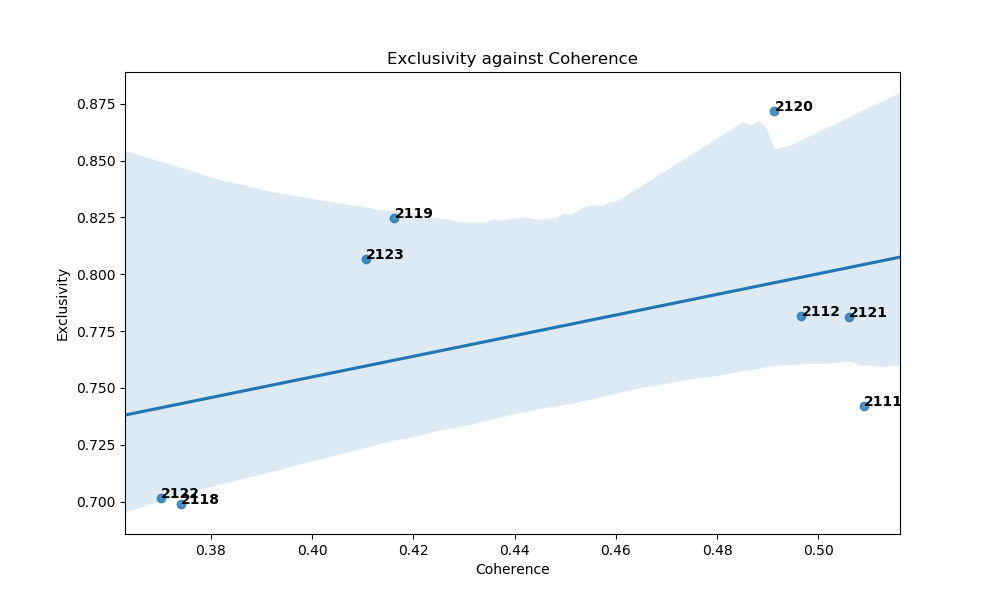

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [8]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,6))
p = sns.regplot(x='coherence', y='exclusivity', data=run_df, ax = ax)

for run_id in run_df.index:
    p.text(run_df.coherence[run_id], run_df.exclusivity[run_id],
           run_id, horizontalalignment='left', size='medium', color='black', weight='semibold')

ax.set(xlabel="Coherence",ylabel="Exclusivity", title="Exclusivity against Coherence")

click on dots to show parameter settings


<IPython.core.display.Javascript object>


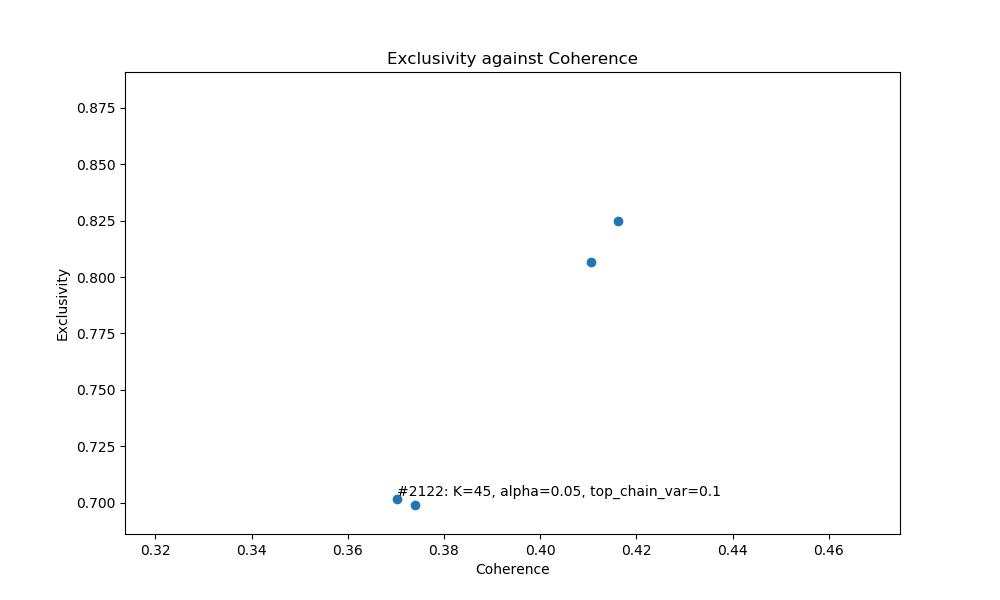

7

In [10]:
print("click on dots to show parameter settings")

# filter:
select_df = run_df[run_df['K'] == 45]
#select_df = run_df

x = select_df['coherence']
y = select_df['exclusivity']

def onpick3(event):
    ind = event.ind[0]
    run_id = select_df.index[ind]
    label = "#{}: K={}, alpha={}, top_chain_var={}".format(run_id, select_df['K'][run_id],
                                                           select_df['alpha'][run_id],
                                                           select_df['top_chain_var'][run_id])
    text.set_text(label)
    text.set_x(x[run_id])
    text.set_y(y[run_id])


fig, ax = plt.subplots(figsize=(10,6))
col = ax.scatter(x, y, picker=5)
ax.set(xlabel="Coherence",ylabel="Exclusivity", title="Exclusivity against Coherence")
text=ax.text(0,0, "", va="bottom", ha="left")

fig.canvas.mpl_connect('pick_event', onpick3)


In [66]:
# measure concentration in the distribution of topics

def gini(x):
    # from https://pysal.readthedocs.io/en/latest/_modules/pysal/inequality/gini.html#Gini
    # see also: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    n = len(x)
    try:
        x_sum = x.sum()
    except AttributeError:
        x = np.asarray(x)
        x_sum = x.sum()
    n_x_sum = n * x_sum
    r_x = (2. * np.arange(1, len(x)+1) * x[np.argsort(x)]).sum()
    return (r_x - n_x_sum - x_sum) / n_x_sum


def gini_array(x, axis=0):
    try:
        n = x.shape[axis]
    except AttributeError:
        x = np.asarray(x)
        n = x.shape[axis]
    m = x.shape[(axis + 1) % 2]
    x_sum = x.sum(axis=axis)
    n_x_sum = n * x_sum
    r_x = np.zeros(m)
    for i in range(m):
        if axis == 1:
            y = x[i]
        else:
            y = x.T[i]
        r_x[i] = (2. * np.arange(1, n + 1) * y[np.argsort(y)]).sum()

        if (r_x[i] - n_x_sum[i] - x_sum[i]) == 0 and n_x_sum[i] == 0:
            n_x_sum[i] = 1

    return (r_x - n_x_sum - x_sum) / n_x_sum

def robin_hood(x):
    """
    Calculate the robin hood (or Hoover) index
    """
    try:
        mean = x.mean()
    except AttributeError:
        x = np.asarray(x)
        mean = x.mean()
    
    return np.abs(x - mean).sum() / (2 * x.sum())

In [67]:
data = []
for run_id in run_ids:
    ts = np.array([score[0] for score in Topic.objects.filter(run_id=run_id).values_list('score')])
    run_df.append([run_id, gini(ts), robin_hood(ts)])
    data.append({'run_id': run_id, 'gini': gini(ts), 'robin_hood': robin_hood(ts)})
ineq_df = pd.DataFrame(data)

In [68]:
ineq_df = ineq_df.sort_values('run_id').set_index('run_id')
df = run_df.join(ineq_df)
df

,K,alpha,coherence,exclusivity,max_iter,rng_seed,top_chain_var,gini,robin_hood
run_id,,,,,,,,,
1898,20,0.01,0.436897,0.496150,50,1,0.005,0.368422,0.257181
1899,30,0.01,0.468952,0.653998,50,1,0.005,0.399618,0.282848
1900,40,0.01,0.482651,0.702931,50,1,0.005,0.452214,0.326824
1905,30,0.01,0.471405,0.661080,200,1,0.005,0.367438,0.267132
1906,25,0.01,0.460576,0.587462,50,1,0.005,0.385014,0.272751
1907,35,0.01,0.491812,0.665818,50,1,0.005,0.463030,0.329466
1915,30,0.01,0.473436,0.679178,200,1,0.005,0.374387,0.258107
1916,25,0.01,0.454914,0.602002,50,1,0.005,0.378788,0.258531
2043,45,0.01,0.471313,0.772562,50,1,0.005,0.475544,0.335114


click on dots to show parameter settings


<IPython.core.display.Javascript object>


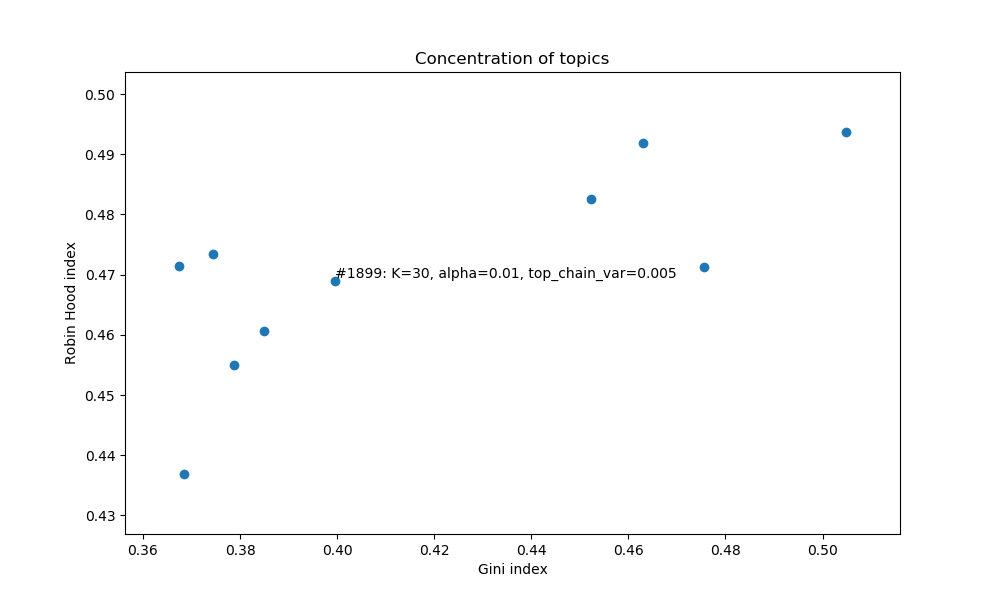

In [71]:
print("click on dots to show parameter settings")

x = df['gini']
y = df['coherence']

def onpick3(event):
    ind = event.ind[0]
    run_id = df.index[ind]
    label = "#{}: K={}, alpha={}, top_chain_var={}".format(run_id, df['K'][run_id],
                                                               df['alpha'][run_id], df['top_chain_var'][run_id])
    text.set_text(label)
    text.set_x(x[run_id])
    text.set_y(y[run_id])


fig, ax = plt.subplots(figsize=(10,6))
col = ax.scatter(x, y, picker=5)
ax.set(xlabel="Coherence",ylabel="Exclusivity", title="Exclusivity against Coherence")
text=ax.text(0,0, "", va="bottom", ha="left")

fig.canvas.mpl_connect('pick_event', onpick3)

ax.set(xlabel="Gini index",ylabel="Robin Hood index", title="Concentration of topics")

<IPython.core.display.Javascript object>


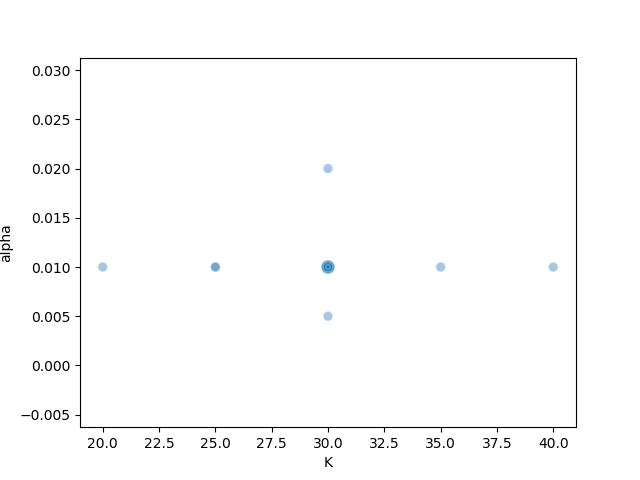

In [43]:
%matplotlib notebook

plt.scatter(x = df.K, 
            y = df.alpha, 
            s = df.top_chain_var*10000,
            alpha=0.4,
            edgecolors='w')

plt.xlabel('K')
plt.ylabel('alpha')

<IPython.core.display.Javascript object>


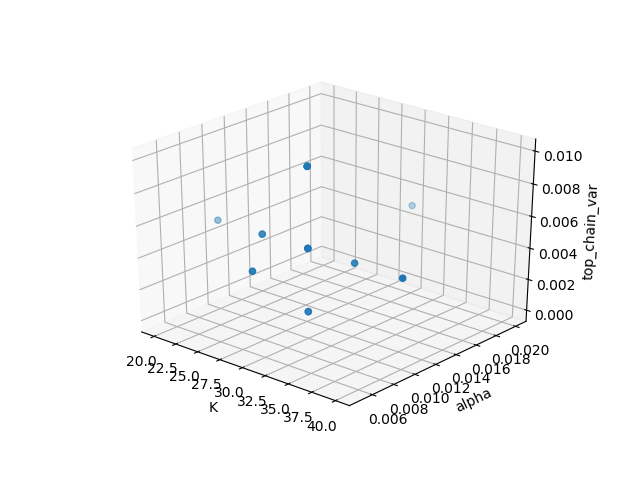

In [32]:
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')

threedee.scatter(df.K, df.alpha, df.top_chain_var)
threedee.set_xlabel('K')
threedee.set_ylabel('alpha')
threedee.set_zlabel('top_chain_var')